# Higgs Tweet - Exploratory Notebook

## Setup

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os, sys, random


In [3]:
"""Load complete unweighted social network graph"""
G = nx.read_edgelist("./Data/higgs-social_network.edgelist",
                     create_using=nx.MultiDiGraph(), nodetype=int, data=(("kind", str),))


# Add Friendship label to each edge in the loaded graph
nx.set_edge_attributes(G, "FR", "kind")

print("Graph loaded:")

Graph loaded:


In [ ]:
"""Load a sample subgraph of the complete SN graph"""
G = nx.read_edgelist("./Data/subgraph_10000.edgelist",
                     create_using=nx.MultiDiGraph(), nodetype=int, data=(("kind", str),))
nx.set_edge_attributes(G, "FR", "kind")

print("Subgraph loaded:")

In [4]:
"""Test Graph"""

print(len(G))
print(len(G.edges))
print(nx.__version__)


456626
14855842
2.0


### Read and summarize the event log and add action edges to the graph

In [5]:
"""
Read activity log into a list of actions
"""

retweet = "RT"
mention = "MT"
reply = "RE"

class Action:
    def __init__(self, u1, u2, t, kind):
        self.u1 = u1
        self.u2 = u2
        self.t = t
        self.kind = kind
    def print(self):
        verbs = {"RT" : "retweeted", "MT" : "mentioned", "RE" : "replied"}
        print("user {} was {} by user {} @ t = {}".format(self.u2, verbs[self.kind], self.u1, self.t))


action_log = []

with open("./Data/higgs-activity_time.txt", "r") as log:
    i=0
    for line in log:
        if i == 0: #skip header
            i+=1
            continue
            
        words = line.split(" ")
        u1 = int(words[0])
        u2 = int(words[1])
        if (u1 in G and u2 in G):
            t = int(words[2])
            kind = words[3].rstrip("\n")
            action = Action(u1, u2, t, kind)
            action_log.append(action)
        else: 
            print("Whoah!")

print(len(action_log))

563069


In [6]:
"""Summarize the action log"""


def num_times_spread_by(u, v):
    return len([_ for a in action_log if a.u1 == u and a.u2 == v])

def num_times_spread(v):
    return len([a.u2 for a in action_log if a.u2 == v])

def num_followers(u):
    return len(list(G.predecessors(u)))

def num_following(u):
    return len(list(G.successors(u)))

for a in action_log[0:10]:
    a.print()

i=0
for u in G:
    if i < 10:
        print("user {} had influence {} times, has {} followers, and follows {} users".format(u, num_times_spread(u), num_followers(u), num_following(u)))
    i += 1

"""
Compute "Friendliness" of events
"""

activities_between_friends = 0
activities_between_strangers = 0

for a in action_log:
    if (G.has_edge(a.u1, a.u2) or G.has_edge(a.u2, a.u1)):
        activities_between_friends += 1
    else:
        activities_between_strangers += 1
        
print(activities_between_friends)
print(activities_between_strangers)

user 213163 was mentioned by user 223789 @ t = 1341100972
user 213163 was replied by user 223789 @ t = 1341100972
user 50329 was retweeted by user 376989 @ t = 1341101181
user 168366 was mentioned by user 26375 @ t = 1341101183
user 13813 was retweeted by user 376989 @ t = 1341101192
user 8 was retweeted by user 453850 @ t = 1341101208
user 8 was mentioned by user 422097 @ t = 1341101251
user 50329 was retweeted by user 99258 @ t = 1341101263
user 364376 was mentioned by user 184615 @ t = 1341101523
user 364376 was replied by user 184615 @ t = 1341101523
user 1 had influence 0 times, has 16280 followers, and follows 22 users
user 2 had influence 3 times, has 4707 followers, and follows 77 users
user 3 had influence 0 times, has 137 followers, and follows 25 users
user 4 had influence 195 times, has 8643 followers, and follows 402 users
user 5 had influence 29 times, has 2194 followers, and follows 58 users
user 6 had influence 186 times, has 27088 followers, and follows 101 users
user 

In [7]:
# G is a MultiDiGraph
print(type(G))

# action_log is the action log
print(len(action_log))

print(len(G.edges))

for a in action_log:
    G.add_edge(a.u1, a.u2, kind=a.kind)
    
print(len(G.edges))



<class 'networkx.classes.multidigraph.MultiDiGraph'>
563069
14855842
15418911


## Write "Weighted Cascade" probs to file

__IC-WC__: IC model with weighted cascade probabilities, that is, each in-coming arc of $v$ has probability $\frac{1}{d_v}$, where $d_v$ is the in-degree of $v$ before removing duplicated arcs. If there are $c(u,v)$ arcs from $u$ to $v$, we have $p_{uv} = 1 - (1 - 1/d(v))^{c(u,v)}$ in the graph with duplicated arcs removed.

### Print edge types in MultiGraph

In [8]:
follow = 0
retweet = 0
mention = 0
reply = 0

for u, v, item in G.edges(data=True): 
    if "kind" in item:
        if item["kind"] == "RT":
            retweet += 1
        elif item["kind"] == "MT":
            mention += 1
        elif item["kind"] == "FR":
            follow += 1
        elif item["kind"] == "RE":
            reply += 1
        else:
            print("Whaaat!")
    else:
        #pass
        sys.exit("Whoa, stop!")
        
print(follow, retweet, mention, reply)

14855842 354930 171237 36902


In [9]:
# Create DiGraph (tar litt tid..)

weights = {"RT" : 0.01, "RE" : 0.001, "RT" : 0.01, "MT" : 0.01, "FR" : 0.01}

D = nx.DiGraph()
D.add_nodes_from(G)
nx.set_edge_attributes(D, 0.0, "weight")
print(len(D.nodes))
print(len(D.edges))

for v in G:
    for u in G.neighbors(v):
        edges = dict(G[v][u])
        weight = 0.0
        for key in edges:
            edge = edges[key]
            weight += weights[edge["kind"]]
        D.add_edge(u, v, weight=weight)

print(len(D.nodes))
print(len(D.edges))


456626
0
456626
15056959


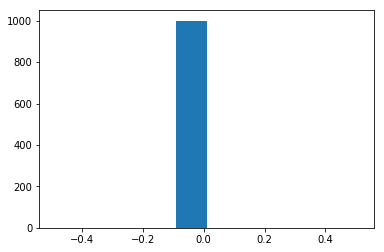

In [12]:
weights = list(nx.get_edge_attributes(D, "weight").values())
plt.figure(1)
plt.hist(weights[:1000])
plt.show()


In [13]:
nx.write_weighted_edgelist(D, "Data/higggs-complete-graph.edgelist")

X = nx.read_weighted_edgelist("Data/higggs-complete-graph.edgelist")
print(len(X))
print(len(X.edges))

456626
12702170


## Plot Degree Distributions

In [ ]:
"""Plot sumary stats: Degree Distributions""" 

in_degree = sorted([d for (n, d) in G.in_degree()], reverse=True)
out_degree = sorted([d for (n, d) in G.out_degree()], reverse=True)
degree = sorted([d for (n, d) in G.degree()], reverse=True)

plt.figure(figsize=(15,5))

#TODO should use histogram

plt.subplot(1, 3, 1)
plt.plot(range(len(G)), in_degree)
plt.title("In-degree dist.")

plt.subplot(1, 3, 2)
plt.plot(range(len(G)), out_degree)
plt.title("Out-degree dist.")

plt.subplot(1, 3, 3)
plt.plot(range(len(G)), degree)
plt.title("Degree dist")

plt.show()

## Sample from Graph

In [ ]:
"""Subsample graph using Random Walks with teleporting"""

epsilon = 0.1
N = 10000
visited = set()
n = len(G)

seed = np.random.choice(n)

while len(visited) < N:
    if len(visited) == 0:
        node = seed
    else:
        jump = np.random.uniform()
        if jump < epsilon:
            #teleport
            node = np.random.choice(n)
        else:
            if len(G[node]) == 0:
                # node has no out-neighbours
                continue
            node = np.random.choice([u for u in G[node]])
        
    visited.add(node)

H = nx.subgraph(G, visited)
nx.write_edgelist(H, "./Data/subgraph_{}.edgelist".format(N))
print(len(H))
del H
del G

## Write top-k nodes to file (in_deg & deg)

In [ ]:
def sort_by_value(arr):
    return arr[np.argsort(-arr[:, 1])]

def get_top_k_indeg(G, k):
    _in =  np.array(G.in_degree()).astype(np.float)
    _in = sort_by_value(_in)
    return _in[0:k, 0]

def get_top_k_deg(G, k):
    _deg =  np.array(G.degree()).astype(np.float)
    _deg = sort_by_value(_deg)
    return _deg[0:k, 0]

def strip_decimal(s):
    return str(s)[:-2]


In [ ]:
"""Output seed-sets of different sizes for different heuristics"""

K = 50

for k in range(1, K+1):

    S = get_top_k_indeg(G, k)

    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/in_deg/in_deg{}.npy".format(k), S)
    
    S = get_top_k_deg(G, k)
    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/deg/deg{}.npy".format(k), S)



## Read and Summarize Activity Log

In [ ]:
"""Compute per-edge influence probabilities"""

nx.set_edge_attributes(action_graph, 0.0, "weight")

weights = {"RT": 1.0, "MT": 1.0, "RE": 1.0}

i = 0
for a in action_log:
    i += 1
    #if i % 1000 == 0:
        #print(i)
    (u1, u2) = (a.u1, a.u2)
    action_graph[u1][u2]["weight"] += weights[a.kind.strip()]
    #i += num_times_spread_by(u1, u2)
      
weights = nx.get_edge_attributes(action_graph, "weight").values()

plt.figure(figsize=(6, 6))
plt.hist(weights, list(range(1,50)))#bins = [1, 2, 3, 4, 6, 8, 10, 100])
#plt.plot(sorted(weights, reverse=True))
plt.title("Action frequency between unique pairs of users")
plt.xlabel("Number of actions between users")
plt.show()

## Write top-k influencial users to file

In [ ]:
def get_top_k_infl(G, k):
    influence = np.array([[u, num_times_spread(u)] for u in G]).astype(np.float)
    influence = sort_by_value(influence)
    return influence[0:k, 0]

K = 50
top_K_influence = get_top_k_infl(G, K)
top_K_influence = list(map(strip_decimal, top_K_influence))

for k in range(1, K+1):
    np.save("Data/seeds/infl/infl{}.npy".format(k), top_K_influence[0:k])
    

In [ ]:
print(top_K_influence[0:10])
print([num_times_spread(u) for u in top_K_influence[0:10]])

## Compute and plot spreads for deg, in_deg & infl

In [ ]:
def prepare_graph(G, world=[0.1, 0.01, 0.001]):
    nx.set_node_attributes(G, False, "visited")
    for (v1, v2) in G.edges:
        G[v1][v2]["weight"] = np.random.choice(world)
    return G

G = prepare_graph(G)

In [ ]:
rand_seeds = []

for i in range(1, 51):
    rand_seeds.append(np.random.choice(list(G.nodes.keys())))
    np.save("Data/seeds/rand/rand{}.npy".format(i), rand_seeds)


In [ ]:
#print(deg_seeds[2])
#G = nx.convert_node_labels_to_integers(G)

os.system("printf '\a'")

In [ ]:
from spread import *

num_seeds = list(range(1, 50))
indeg_spreads = []
deg_spreads = []
infl_spreads = []
rand_spreads = []

for i in num_seeds:
    print("Computing spreads for {} seeds".format(i))
    indeg_seeds = np.load("Data/seeds/in_deg/in_deg{}.npy".format(i))
    #deg_seeds = np.load("Data/seeds/deg/deg{}.npy".format(i))
    #infl_seeds = np.load("Data/seeds/infl/infl{}.npy".format(i))
    rand_seeds = np.load("Data/seeds/rand/rand{}.npy".format(i))
    
    (indeg_n, _) = get_expected_spread(G, indeg_seeds, 100, mean=True)
    #(deg_n, _) = get_expected_spread(G, deg_seeds, 100, mean=True)
    (rand_n, _) = get_expected_spread(G, rand_seeds, 100, mean=True)
    #(infl_n, _) = get_expected_spread(G, infl_seeds, 100, mean=True)
    
    indeg_spreads.append(indeg_n)
    #deg_spreads.append(deg_n)
    rand_spreads.append(rand_n)
    #infl_spreads.append(infl_n)
    
os.system("printf '\a'")

plt.plot(num_seeds, indeg_spreads, c='k')
#plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seeds, rand_spreads, c='y')
#plt.plot(num_seeds, infl_spreads, c='r')

plt.show()

In [ ]:
plt.plot(num_seeds, indeg_spreads, c='k')
plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seed, infl_spreads, c='r')
plt.plot(num_seeds, rand_spreads, c='y')

plt.show()

np.save("Data/spreads/rand_spreads", indeg_spreads)
np.save("Data/spreads/indeg_spreads", indeg_spreads)
np.save("Data/spreads/deg_spreads", deg_spreads)
np.save("Data/spreads/infl_spreads", infl_spreads)

In [ ]:
print(nx.__version__)

print(np.median([d for (_, d) in G.out_degree()]))
print(nx.number_connected_components(G.to_undirected()))

C = nx.connected_components(G.to_undirected())

print([len(c) for c in C])

## Community Detection Stuff

In [ ]:
"""
Partition the graph into communities, save a community for further work
"""
import networkx.algorithms.community as community

communities = community.girvan_newman(G)

comm = next(communities)

while True:
    
    comm = next(communities)
    
    comm_sizes = [len(c) for c in comm]
    
    if max(comm_sizes) < 500:
        print("Found a partition of comminities with max-size 500")
        break;
    print("Found nothing, moving on")
    